In [96]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing

In [97]:
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

# Variable selection
temp = ds.votemper
saline = ds.vosaline
date = pd.DatetimeIndex(ds['time_counter'].values)

# Biological variables
sil = ds_bio.silicon
nitr = ds_bio.nitrate
ammo = ds_bio.ammonium

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

In [98]:
# The spots appear on depth 11 onwards

depth = 11   
temp = temp.where(mask[0,depth]==1)
saline = saline.where(mask[0,depth]==1)

sil = sil.where(mask[0,depth]==1)
nitr= nitr.where(mask[0,depth]==1)
ammo = ammo.where(mask[0,depth]==1)

In [99]:
# Post processing 
inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
inputs2 = inputs[:,indx[:,0]]
inputs3 = preprocessing.normalize(inputs2, norm= 'max')
inputs3 = inputs3.transpose()

# SOM
temp_som = SOM(m=3, n=2, dim= inputs3[0,:].size, lr = 0.1)
temp_som.fit(inputs3, epochs = 5)
predictions = temp_som.predict(inputs3)

# Post processing
unique, counts = np.unique(predictions, return_counts=True)
indx2 = np.full(inputs[0,:].size,np.nan)
indx2[indx[:,0]] = predictions
clusters = np.reshape(indx2,(898,398))  

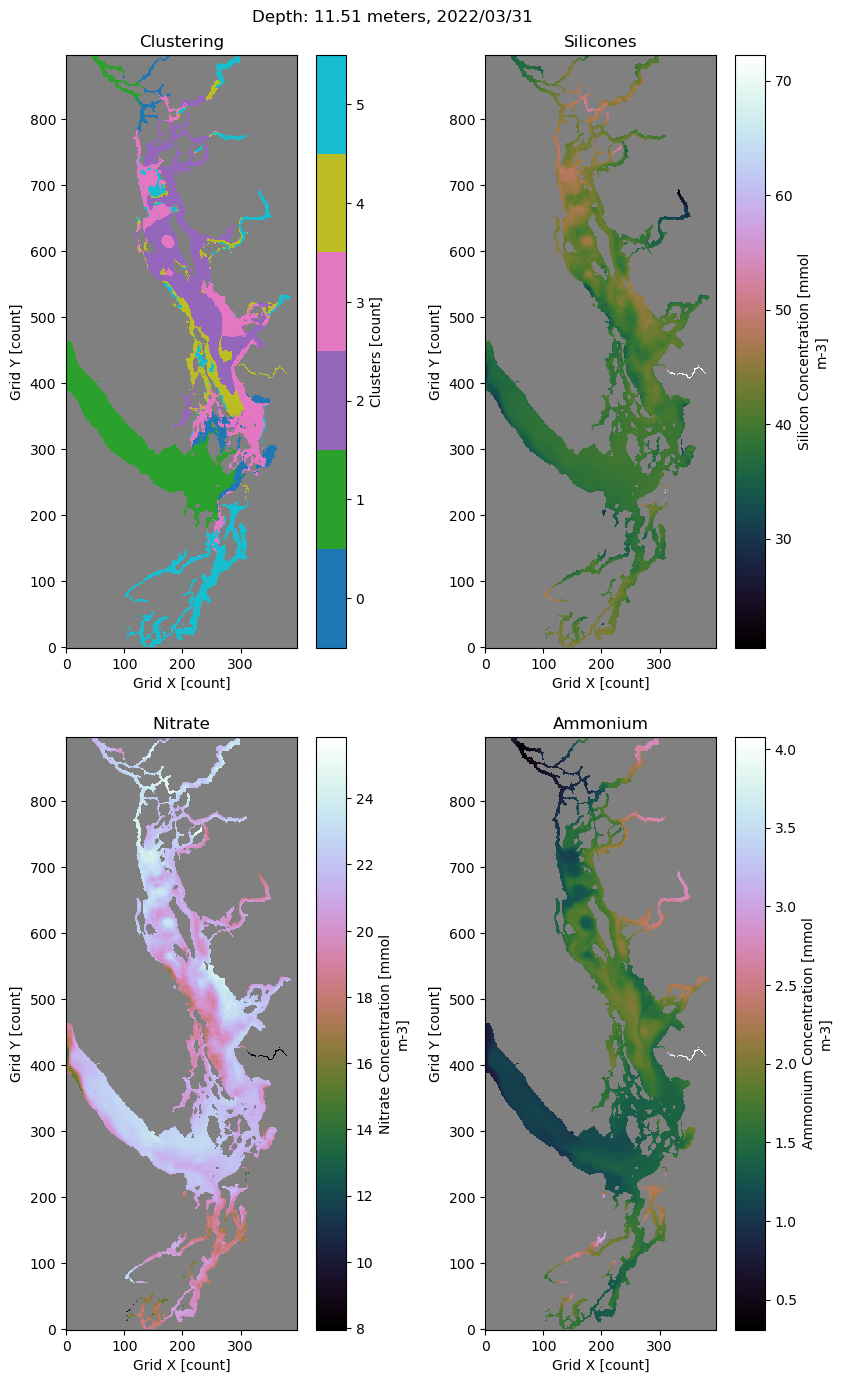

In [100]:
# Preparation of the dataarray 
map = xr.DataArray(clusters,
                coords = {'y': sil[0,depth].y, 'x': sil[0,depth].x},
                dims = ['y','x'],
                attrs=dict(description="Clusters of the performed self organizing map algorithm",
                            long_name ="Cluster",
                            units="count"),
                ) 

cmap = plt.get_cmap('tab10', unique.max()+1)
cmap.set_bad('gray')
fig, ax = plt.subplots(2,2, figsize=(10, 15))
clus = map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

cbar = fig.colorbar(clus, ticks = unique+0.5) 
cbar.set_ticklabels(unique)
cbar.set_label('Clusters [count]')

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.1, 
    hspace=0.15)
        
cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')
sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
nitr[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
ammo[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

sa_vi.set_aspect(ax[0,0])
sa_vi.set_aspect(ax[0,1])
sa_vi.set_aspect(ax[1,0])
sa_vi.set_aspect(ax[1,1])

ax[0,0].title.set_text('Clustering')
ax[0,1].title.set_text('Silicones')
ax[1,0].title.set_text('Nitrate')
ax[1,1].title.set_text('Ammonium')

if date[0].month < 10:
    month = '0' + str(date[0].month)
else:
    month = str(date[0].month)

if date[0].day < 10:
    day = '0' + str(date[0].day)  
else:
    day = str(date[0].day) 

fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
plt.show()

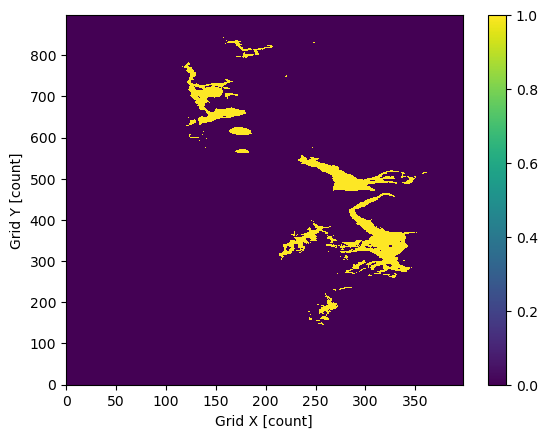

In [101]:
(map==3).plot()

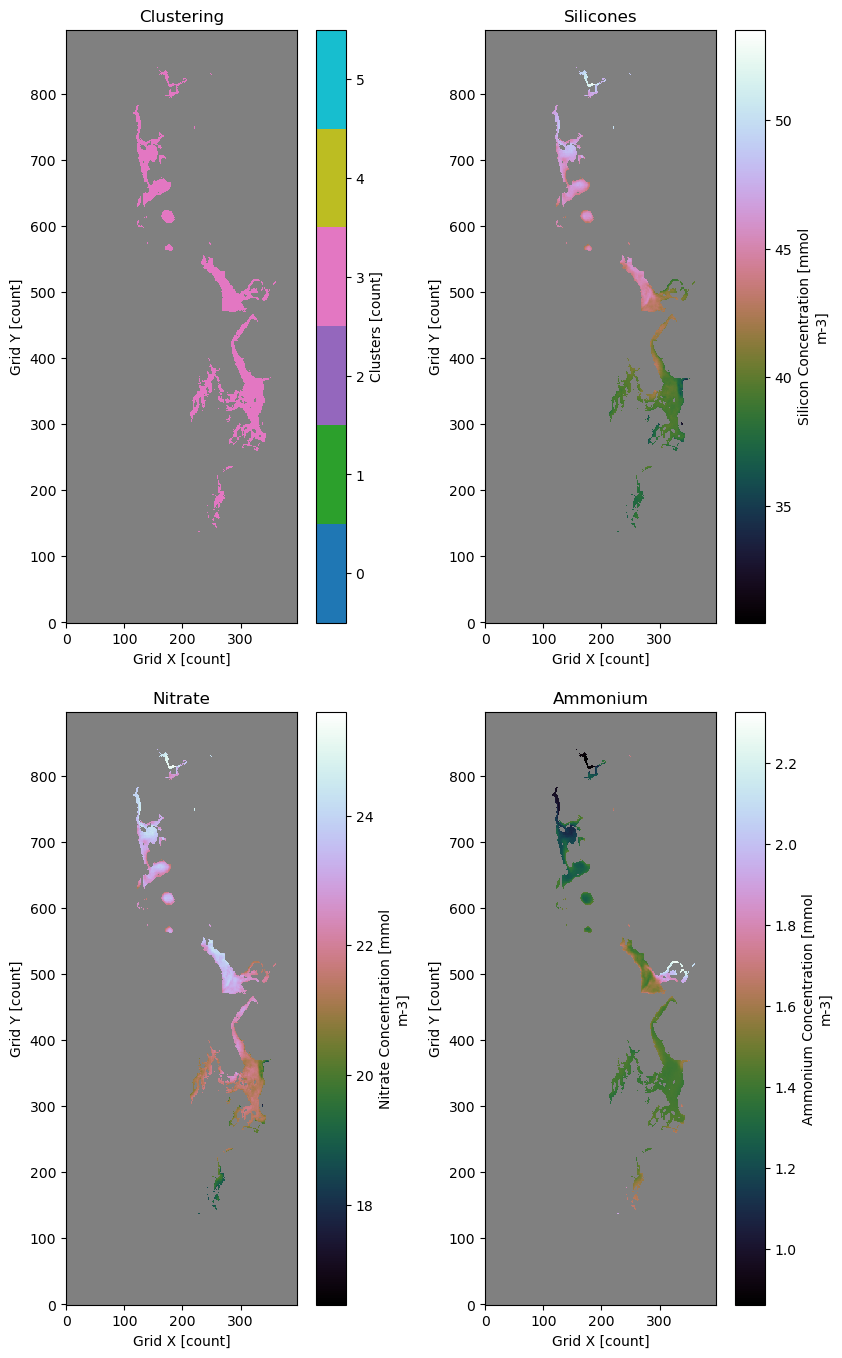

In [102]:
cmap = plt.get_cmap('tab10', unique.max()+1)
cmap.set_bad('gray')
fig, ax = plt.subplots(2,2, figsize=(10, 15))
clus = map.where(map==3).plot.pcolormesh(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

cbar = fig.colorbar(clus, ticks = unique+0.5) 
cbar.set_ticklabels(unique)
cbar.set_label('Clusters [count]')

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.1, 
    hspace=0.15)

cmap = plt.get_cmap('cubehelix')
cmap.set_bad('gray')
sil[0,depth].where(map==3).plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
nitr[0,depth].where(map==3).plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
ammo[0,depth].where(map==3).plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

sa_vi.set_aspect(ax[0,0])
sa_vi.set_aspect(ax[0,1])
sa_vi.set_aspect(ax[1,0])
sa_vi.set_aspect(ax[1,1])

ax[0,0].title.set_text('Clustering')
ax[0,1].title.set_text('Silicones')
ax[1,0].title.set_text('Nitrate')
ax[1,1].title.set_text('Ammonium')

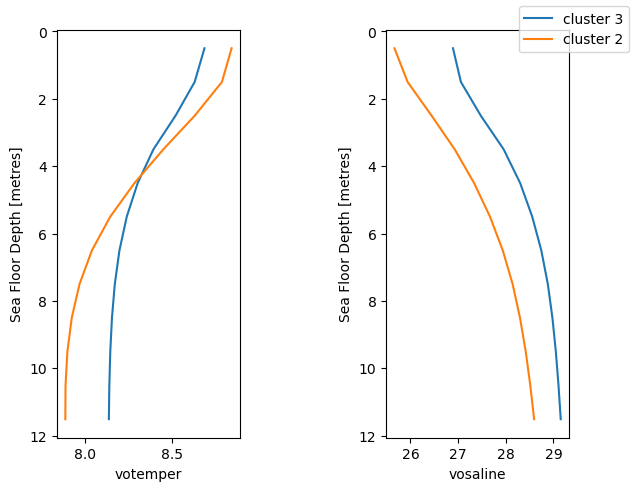

In [118]:
# For the whole cluster

fig, axs = plt.subplots(ncols=2)

temp[0,0:12].where(map==3).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'cluster 3')
temp[0,0:12].where(map==2).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'cluster 2')

saline[0,0:12].where(map==3).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])
saline[0,0:12].where(map==2).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].title.set_text(' ')
axs[1].title.set_text(' ')
fig.legend()

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.8, 
    hspace=0.15)


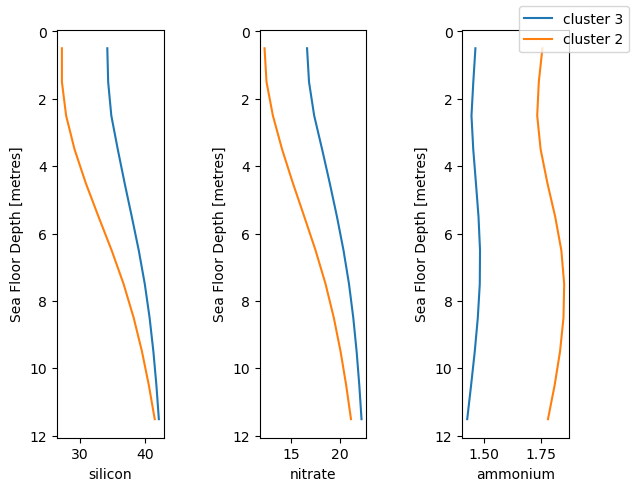

In [123]:
# For the whole cluster

fig, axs = plt.subplots(ncols=3)

sil[0,0:12].where(map==3).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'cluster 3')
sil[0,0:12].where(map==2).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'cluster 2')

nitr[0,0:12].where(map==3).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])
nitr[0,0:12].where(map==2).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])

ammo[0,0:12].where(map==3).mean(dim=['x','y']).plot(y='deptht', ax=axs[2])
ammo[0,0:12].where(map==2).mean(dim=['x','y']).plot(y='deptht', ax=axs[2])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].title.set_text(' ')
axs[1].title.set_text(' ')
axs[2].title.set_text(' ')
fig.legend()

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.9, 
    hspace=0.15)

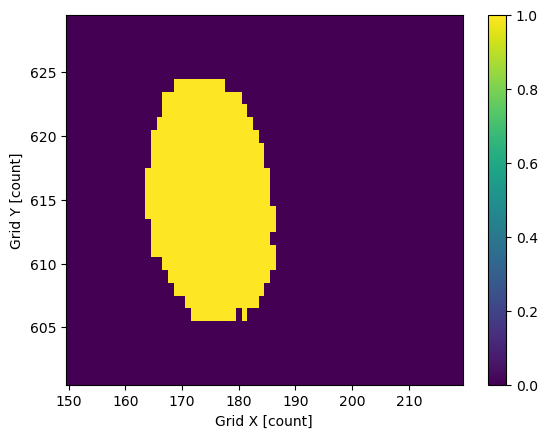

In [107]:
(map==3).isel(y=slice(601, 630), x=slice(150,220)).plot()

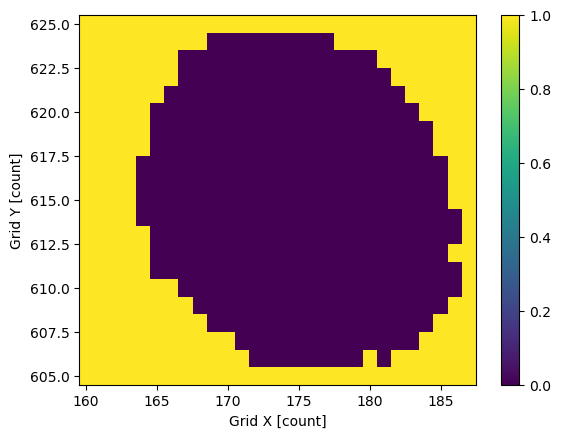

In [124]:
(map==2).isel(y=slice(605, 626), x=slice(160,188)).plot()

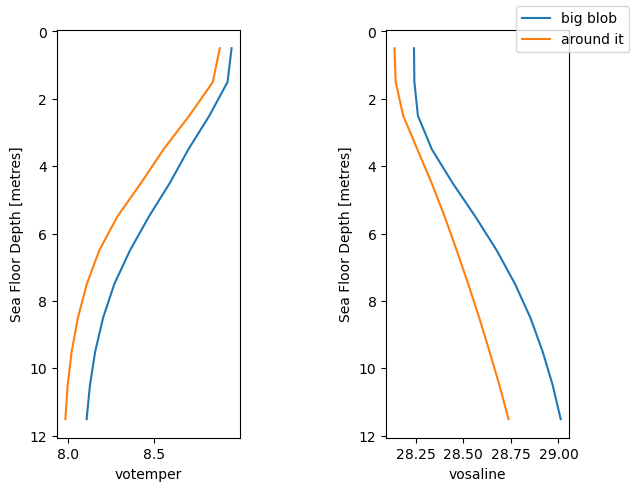

In [128]:
# For the big blob

fig, axs = plt.subplots(ncols=2)

temp[0,0:12].where(map==3).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'big blob')
temp[0,0:12].where(map==2).isel(y=slice(605, 626), x=slice(160,188)).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'around it')

saline[0,0:12].where(map==3).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])
saline[0,0:12].where(map==2).isel(y=slice(605, 626), x=slice(160,188)).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].title.set_text(' ')
axs[1].title.set_text(' ')
fig.legend()

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.8, 
    hspace=0.15)

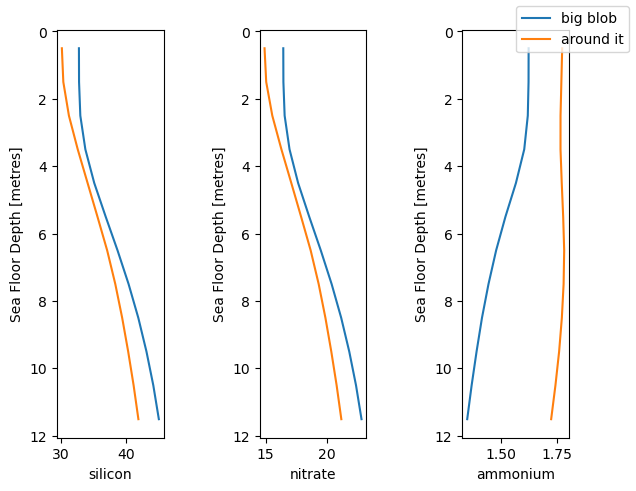

In [127]:
# For the big blob

fig, axs = plt.subplots(ncols=3)

sil[0,0:12].where(map==3).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'big blob')
sil[0,0:12].where(map==2).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[0], label = 'around it')

nitr[0,0:12].where(map==3).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])
nitr[0,0:12].where(map==2).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[1])

ammo[0,0:12].where(map==3).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[2])
ammo[0,0:12].where(map==2).isel(y=slice(601, 630), x=slice(150,220)).mean(dim=['x','y']).plot(y='deptht', ax=axs[2])

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()

axs[0].title.set_text(' ')
axs[1].title.set_text(' ')
axs[2].title.set_text(' ')
fig.legend()

plt.subplots_adjust(left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.95, 
    wspace=0.9, 
    hspace=0.15)

Text(0.5, 1.0, 'SOM Clustering (2022/03/31)')

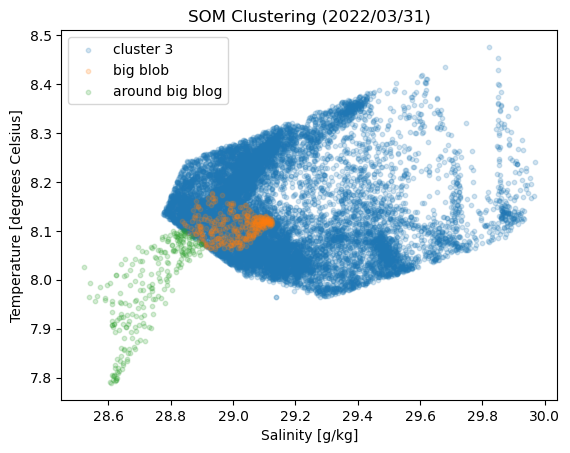

In [137]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('tab20', unique.max()+1)

plt.scatter(saline[0,11].where(map==3), temp[0,11].where(map==3), alpha = 0.2, s = 10)

plt.scatter(saline[0,11].where(map==3).isel(y=slice(601, 630), x=slice(150,220)), temp[0,11].where(map==3).isel(y=slice(601, 630), x=slice(150,220)), alpha = 0.2, s= 10)

plt.scatter(saline[0,11].where(map==2).isel(y=slice(605, 626), x=slice(160,188)), temp[0,11].where(map==2).isel(y=slice(605, 626), x=slice(160,188)), alpha = 0.2, s = 10)

plt.legend(['cluster 3', 'big blob', 'around big blog'])

plt.xlabel('Salinity [g/kg]')
plt.ylabel('Temperature [degrees Celsius]')
plt.title('SOM Clustering' + ' (' + str(date[0].year) + '/' + month + '/' + day + ')')

Text(0.5, 1.0, 'SOM Clustering (2022/03/31)')

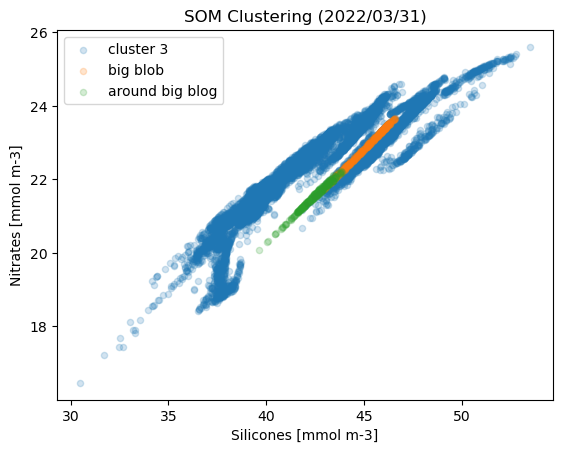

In [141]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('tab20', unique.max()+1)

plt.scatter(sil[0,11].where(map==3), nitr[0,11].where(map==3), alpha = 0.2, s = 20)

plt.scatter(sil[0,11].where(map==3).isel(y=slice(601, 630), x=slice(150,220)), nitr[0,11].where(map==3).isel(y=slice(601, 630), x=slice(150,220)), alpha = 0.2, s = 20)

plt.scatter(sil[0,11].where(map==2).isel(y=slice(605, 626), x=slice(160,188)), nitr[0,11].where(map==2).isel(y=slice(605, 626), x=slice(160,188)), alpha = 0.2, s = 20)

plt.legend(['cluster 3', 'big blob', 'around big blog'])

plt.xlabel('Silicones [mmol m-3]')
plt.ylabel('Nitrates [mmol m-3]')
plt.title('SOM Clustering' + ' (' + str(date[0].year) + '/' + month + '/' + day + ')')